# Input Sampling notebook

---

This notebook is used to create an initial dataset, by sampling from multiple sources from the internet.
The goal is to obtain multiple formats of files that create visual outputs:
- svg
- tikz
- html-css-js
- ascii art
- P5js
- scad

The output will be a huggingface dataset with only image and code(pil image ans str)

## SVG

#### Selected source
- https://huggingface.co/datasets/ServiceNow/svg-emoji
#### Policies
- No \<animate>, \<animateMotion>, \<animateTransform>, \<set>
- No <text>
- At least one of (\<circle>,\<rect>,\<ellipse>,\<polygon>,\<polyline>,\<line>)
- Number of characters > Cmin
- Number of characters < Cmax

#### Statistics

In [ ]:
import re
from datasets import load_dataset

from input_utils import SvgFilters

ds_initial = load_dataset("ServiceNow/svg-emoji",split="train")

SvgFilters.statistics(ds_initial)

#### Filtering

In [ ]:
ds = ds_initial.filter(SvgFilters.noAnimations, desc="filtering out animated svgs")
ds = ds.filter(SvgFilters.noText, desc="filtering out svgs with texts")
ds = ds.filter(SvgFilters.hasBasicShape, desc="filtering out svgs without basic shapes")
ds = ds.filter(
    SvgFilters.maxCharacters,
    desc="filtering svgs under 4500 caracters and over 500",
)
ds.cleanup_cache_files()

#### Pushing the current subset

In [ ]:
ds = ds.rename_columns({"Filename":"name","Svg":"code"})
ds.push_to_hub("CharlyR/varbench-inputs", config_name="svg", split="auto_filtered")


## TIKZ

#### Selected source
- nllg/datikz
- CharlyR/varbench => source codes do not need to be filtered
#### Policies
- Has any comments => more chances of having challenging TikZ
  - Then Remove comments
- between 1700 and 2300 characters=> to match varbench, not too easy not too hard
- more than 3 \draw or \fill directives
- only one \begin{tikzpicture}
- Source not gpt4 chatgpt => "after manual exploration of the dataset, we found that tikz codes coming from gpt4 or chatgpt sources were too simple and not representative of real scientific diagrams"

#### Modifications

In [ ]:
from datasets import load_dataset,Dataset
from input_utils import TikzUtils
ds:Dataset = load_dataset("nllg/datikz",split="train")
#ds.cleanup_cache_files()

/home/creux/miniconda3/envs/varbench/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


6

#### Statistics

computing length of the code: 100%|██████████| 49692/49692 [00:03<00:00, 13174.35 examples/s]


-1158.5
3709.5


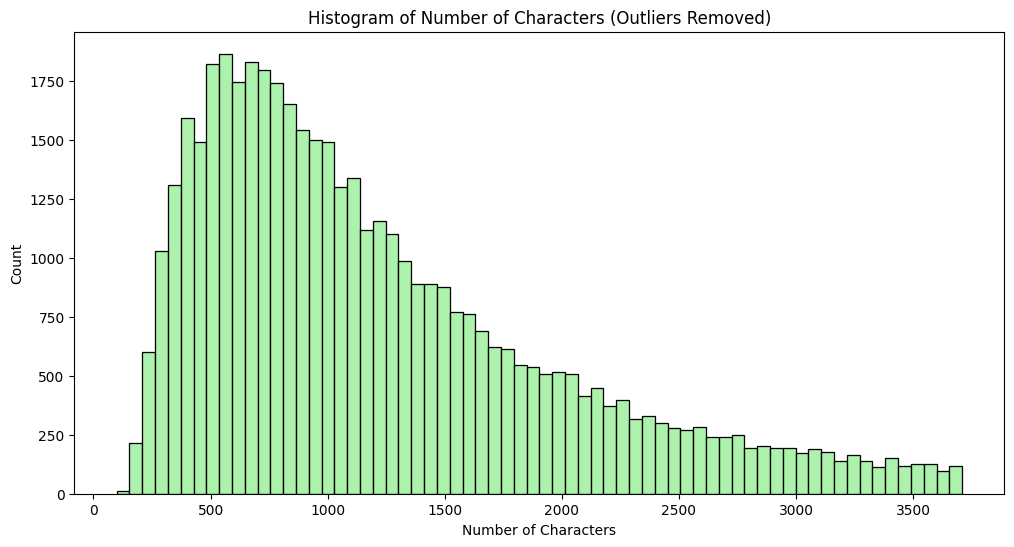

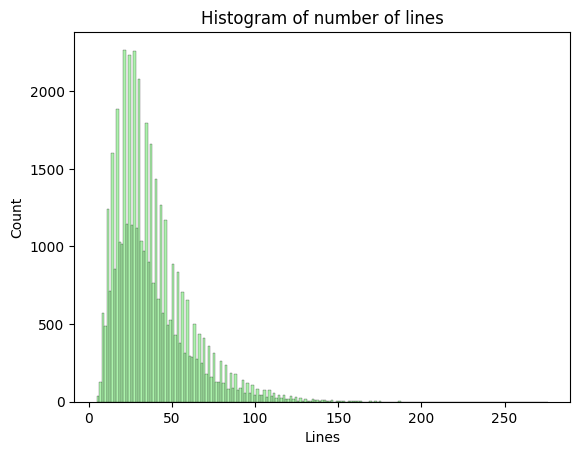

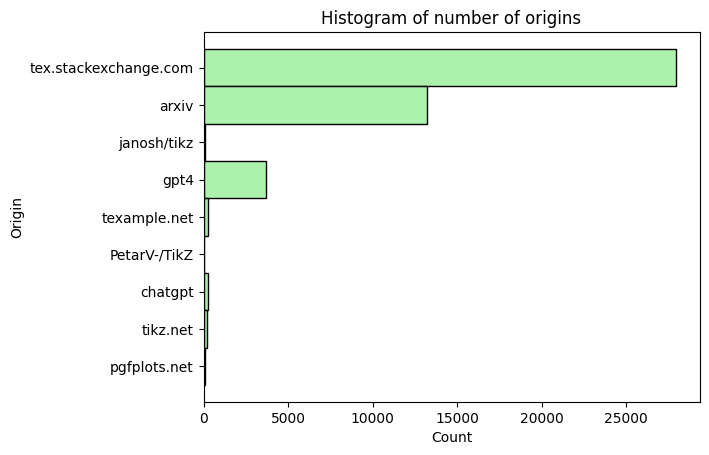

In [2]:

TikzUtils.statistics(ds)#outliers removed



### Filtering and modifications

In [2]:
ds = ds.filter(TikzUtils.Filters.hasComments, desc="filtering out tikz without comments")
print(len(ds))
ds = ds.map(TikzUtils.Modifications.removeComments, desc="Removing comments")
print(len(ds))
ds = ds.filter(TikzUtils.Filters.characterLength, desc="filtering out tikz with character lenght l:700<l<3570")
print(len(ds))
#ds = ds.filter(TikzUtils.Filters.lineLength, desc="filtering out tikz with line lenght l:50<l<80")
#print(len(ds))
ds = ds.filter(TikzUtils.Filters.hasBasicShape, desc="filtering out tikz without basic tikz shapes")
print(len(ds))
ds = ds.filter(TikzUtils.Filters.oneTikzPicture, desc="filtering out tikz with only one \\begin{tikzpicture}")
print(len(ds))
ds = ds.filter(TikzUtils.Filters.noLLMorigin, desc="filtering out tikz with LLM origin")
print(len(ds))


filtering out tikz without comments: 100%|██████████| 49692/49692 [00:41<00:00, 1194.85 examples/s]


7975


Removing comments: 100%|██████████| 7975/7975 [00:01<00:00, 5052.84 examples/s]


7975


filtering out tikz with character lenght l:700<l<3570: 100%|██████████| 7975/7975 [00:06<00:00, 1187.83 examples/s]


5606


filtering out tikz without basic tikz shapes: 100%|██████████| 5606/5606 [00:04<00:00, 1159.48 examples/s]


3001


filtering out tikz with only one \begin{tikzpicture}: 100%|██████████| 3001/3001 [00:02<00:00, 1180.40 examples/s]


2750


filtering out tikz with LLM origin: 100%|██████████| 2750/2750 [00:02<00:00, 1200.37 examples/s]

2750


##### manual exploration

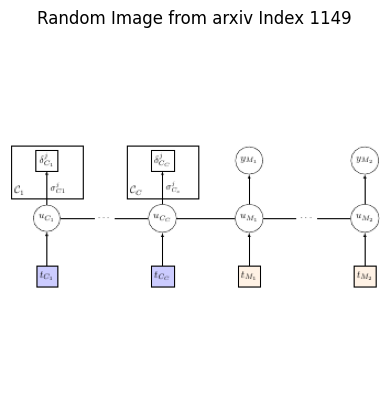

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image
tmpds = ds

# Pick a random index
idx = random.randint(0, len(tmpds) - 1)
# Load image
image = tmpds[idx]["image"]  # Adjust key if needed
# Convert to PIL image if necessary
if isinstance(image, dict) and "bytes" in image:
    image = Image.open(io.BytesIO(image["bytes"]))
# Display image
plt.imshow(image)
plt.axis("off")
plt.title(f"Random Image from {tmpds[idx]["origin"]} Index {idx}")
plt.show()
with open("tmp.tex","w") as t:
    t.write(tmpds[idx]["full_code"])

#### Manual Selection

27


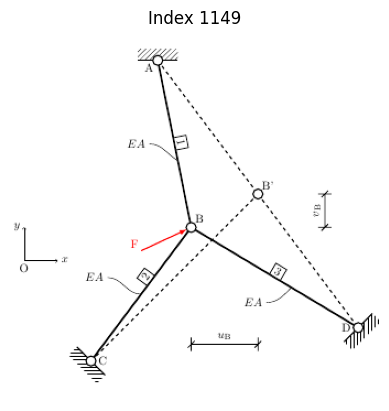

In [ ]:
potentials = [764,969,2379,444,1816,47,1343,902,201,639,667,2098,434,2696,238,2355,1976,580,824,584,2746,1802,221,1761,1920,599,1149]
print(len(potentials))
id=11
image = tmpds[potentials[id]]["image"]  # Adjust key if needed
# Convert to PIL image if necessary
if isinstance(image, dict) and "bytes" in image:
    image = Image.open(io.BytesIO(image["bytes"]))
# Display image
plt.imshow(image)
plt.axis("off")
plt.title(f"Index {idx}")
plt.show()
with open("tmp.tex","w") as t:
    t.write(tmpds[potentials[id]]["full_code"])

#### Pushing the current subset

In [ ]:

import datasets
import pandas as pd
ds = datasets.Dataset.from_pandas(pd.DataFrame(data=all_sources))
ds.push_to_hub("CharlyR/varbench-inputs", config_name="tikz", split="auto_filtered")


NameError: name 'all_sources' is not defined

## P5js

#### Selected source
- https://happycoding.io/tutorials/p5js/ ?
- https://openprocessing.org/discover/#/trending
#### treatment
- Comments removal
#### Policies
- handpicked example from the sites